# EMNLP 2022 (NLLP)
## Semantic Legal Searcher : Faster Natural Language-based Semantic Search for Case Law

## 0. Import

In [ ]:
! pip install transformers
! pip install -U sentence-transformers
! pip install sentencepiece
! pip install faiss-gpu
! pip install pytrends
! pip install funcy pickle5

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util

## 1. Legal Database (Original Korean Case Law)

In [5]:
# Load Legal Dataset(Get Only Judicial precedent data)
df = pd.read_csv('./data/law_cases(20220829).csv')
df = df.dropna(how='any')
# Make index for clustering
print(">> Judicial precedent data size : ",len(df))

df.head()

>> Judicial precedent data size :  62415


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm
0,압수물가환부불허결정에대한준항고일부인용결정에대한재항고,2020모735,20220630,400102.0,수사기관이 압수·수색영장에 적힌 ‘수색할 장소’에 있는 컴퓨터 등 정보처리장치에...,"헌법과 형사소송법이 구현하고자 하는 적법절차와 영장주의의 정신에 비추어 볼 때,...",【준항고인】 ○○○○○○○○○ 주식회사【변 호 인】 법무법인(유한) 화우 담당변호사...,83459,6591,0.655657
1,의사면허취소처분취소[의료법위반죄로 금고 이상의 형의 집행유예를 선고받은 자가 유예기...,2021두62171,20220630,400107.0,면허취소사유를 정한 구 의료법 제65조 제1항 단서 제1호의 ‘제8조 각호의 어...,"구 의료법(2016. 5. 29. 법률 제14220호로 개정되기 전의 것, 이하 ‘...","【원고, 상고인】 원고 (소송대리인 법무법인(유한) 원 담당변호사 이주웅 외 3인)...",83458,7709,0.768586
2,양수금[타인의 은행계좌로 송금한 금액이 착오송금임을 주장하며 그 수취은행을 상대로 ...,2016다237974,20220630,400101.0,[1] 예금거래기본약관에 따라 송금의뢰인이 수취인의 예금계좌에 자금이체를 하여 ...,"[1] 자금이체는, 은행 간 및 은행점포 간의 송금절차를 통하여 저렴한 비용으로...","【원고, 상고인】 주식회사 비엔씨 (소송대리인 법무법인 에이디엘 담당변호사 양창길 ...",83457,9245,0.923737
3,정산금등청구의소,2022다200089,20220630,400101.0,채권양수인이 양수채권을 자동채권으로 하여 채무자가 채권양수인에 대해 가지고 있던...,"민법 제493조 제2항은 ""상계의 의사표시는 각 채무가 상계할 수 있는 때에 대등액...","【원고, 상고인】 주식회사 티머니 (소송대리인 법무법인(유한) 충정 담당변호사 김성...",83456,1522,0.143636
4,무고,2022도3413,20220630,400102.0,무고죄의 성립요건 및 ‘형사처분을 받게 할 목적’의 인정 범위 / 무고죄의 고의...,무고죄는 타인으로 하여금 형사처분이나 징계처분을 받게 할 목적으로 신고한 사실이...,【피 고 인】 피고인【상 고 인】 피고인【변 호 인】 법무법인 케이앤비 담당변호사 ...,83455,272,0.017374


In [6]:
def text_len_plot(dataframe, col):
    """
    dataframe : DataFrame
    col : str(Column name)
    """
    dataframe['text_len'] = dataframe[col].apply(lambda words : len(words.split()))
    #dataframe['sent_len'] = dataframe[col].apply(lambda words : len(words.split(".")))
    mean_seq_len = np.round(dataframe['text_len'].mean() + dataframe['text_len'].std()).astype(int)
    #mean_sent_len = np.round(dataframe['sent_len'].mean() + dataframe['sent_len'].std()).astype(int)
    print(">> {} Average Text length : {}".format(col, mean_seq_len))
    print(">> {} Max Text length : {}".format(col, dataframe['text_len'].max()))
    print(">> {} Text words : {}".format(col, dataframe['text_len'].sum()))

    plt.figure(figsize=(12,6))
    sns.histplot(dataframe['text_len'], kde=True, color='royalblue', label='Text_length')
    plt.axvline(x=mean_seq_len, color='r', linestyle='--', label='max_length')
    plt.title('Text length'); plt.legend()
    plt.show()

>> judgment_issue Average Text length : 60
>> judgment_issue Max Text length : 611
>> judgment_issue Text words : 1872423


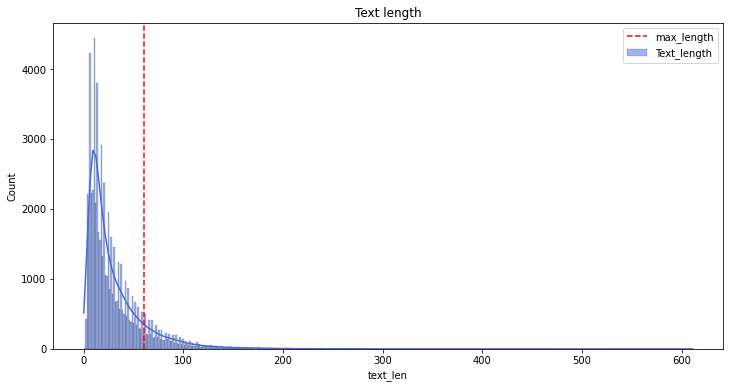

>> judgment_summary Average Text length : 209
>> judgment_summary Max Text length : 2849
>> judgment_summary Text words : 6432672


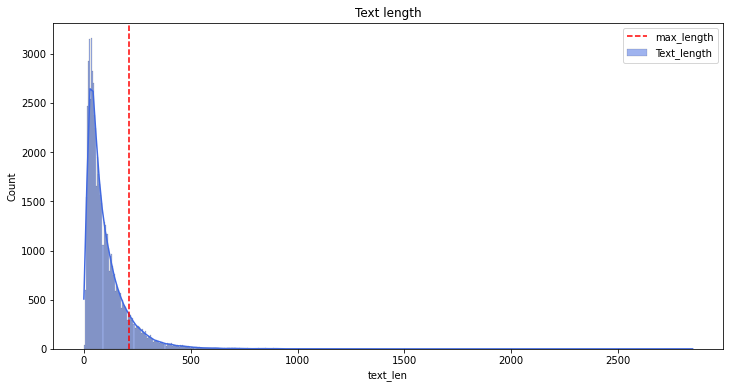

>> judgment_contents Average Text length : 1465
>> judgment_contents Max Text length : 37418
>> judgment_contents Text words : 41752381


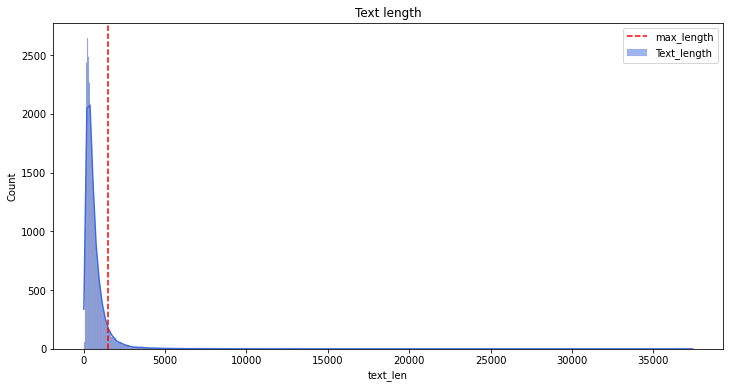

>> case_name Average Text length : 2
>> case_name Max Text length : 57
>> case_name Text words : 71434


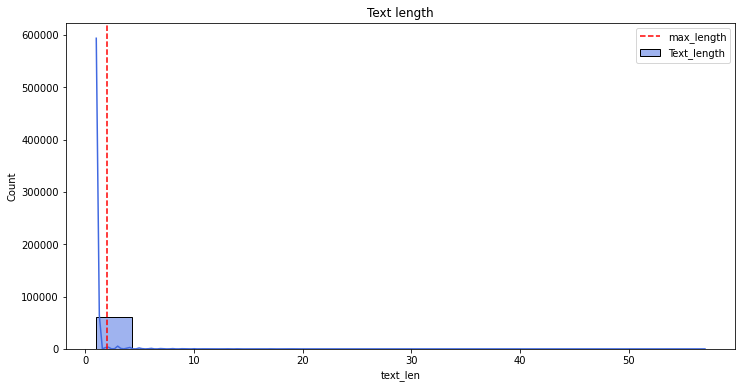

In [7]:
# Text Length
# 1. Judgment_issue
text_len_plot(df, 'judgment_issue')
# 2. judgment_summary
text_len_plot(df, 'judgment_summary')
# 3. judgment_full-text
text_len_plot(df, 'judgment_contents')
# 4. case_name
text_len_plot(df, 'case_name')

## STEP 1 : Load Pre-Trained Language model

In [8]:
# Load supervised or unsupervised fine-tuned models
my_model = './output/nil_sts_tsdae-bert'

## STEP 2 : Parallel Clustering-based Topic Modeling

In [9]:
from models.parallel_topic_model import *

In [10]:
target_column = 'judgment_summary'

cluster = ParallelCluster(
    dataframe = df,
    tgt_col = target_column,
    model_name = my_model,
    use_sentence_bert = True
    )

Batches:   0%|          | 0/1951 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62415, 768)


In [11]:
# 1. Parallel Embedding Clustering
clusters, unclusters = cluster.parallel_cluster(
    clusters = None,
    threshold = 0.78,
    page_size = 2500,
    iterations = 15
    )

=== Iteration 1 / 15 ===


>> Number of Total Clusters :  349
>> Percentage clusted Doc Embeddings : 10.76%


=== Iteration 2 / 15 ===


>> Number of Total Clusters :  623
>> Percentage clusted Doc Embeddings : 16.00%


=== Iteration 3 / 15 ===


>> Number of Total Clusters :  810
>> Percentage clusted Doc Embeddings : 18.75%


=== Iteration 4 / 15 ===


>> Number of Total Clusters :  942
>> Percentage clusted Doc Embeddings : 20.29%


=== Iteration 5 / 15 ===


>> Number of Total Clusters :  1054
>> Percentage clusted Doc Embeddings : 21.57%


=== Iteration 6 / 15 ===


>> Number of Total Clusters :  1150
>> Percentage clusted Doc Embeddings : 22.64%


=== Iteration 7 / 15 ===


>> Number of Total Clusters :  1229
>> Percentage clusted Doc Embeddings : 23.49%


=== Iteration 8 / 15 ===


>> Number of Total Clusters :  1296
>> Percentage clusted Doc Embeddings : 24.18%


=== Iteration 9 / 15 ===


>> Number of Total Clusters :  1359
>> Percentage clusted Doc Embeddings : 24.75%


=== I

In [12]:
# 2. Stack : Stack the clustered results in order of cluster size
col_list = ['case_name', 'case_number', 'date', 'case_code',
            'judgment_issue', 'judgment_summary', 'judgment_contents',
            'case_id', 'case_hits', 'case_hits_norm']

new_df = cluster.cluster_stack(
    col_list = col_list,
    clusters = clusters,
    unclusters = unclusters
    )

# 3. Topic Modeling : Extract Latent Topics (or Keywords)
top_n_words = cluster.extract_top_n_words_per_topic(
    dataframe = new_df,
    n = 20,
    en = False
    )

new_df['Topic_Modeling'] = [top_n_words[i] for i in new_df['Topic'].values]

new_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['못하다', '아니다', '안된다', '않고', '않기', '없고', '하기'] not in stop_words.
  % sorted(inconsistent)
/content/drive/MyDrive/NLLP_2022/models/parallel_topic_model.py:400: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,case_name,case_number,date,case_code,judgment_issue,judgment_summary,judgment_contents,case_id,case_hits,case_hits_norm,Topic,Topic_Modeling
76,사기미수,2022도1227,20220526,400102.0,[1] 소송사기를 인정할 때 유의할 사항 / 소송사기가 성립하기 위한 요건 [...,[1] 소송사기는 법원을 기망하여 자기에게 유리한 판결을 얻음으로써 상대방의 재...,【피 고 인】 피고인【상 고 인】 피고인【변 호 인】 법무법인 한로 담당변호사 홍임...,83383,9571,0.956667,0,"[(채무자의, 0.017245295932515944), (채무자가, 0.017111..."
153,청구이의,2021다299372,20220414,400101.0,공정증서가 작성된 약속어음의 원인채권 이행기가 도래하지 아니하였다는 사유가 청구...,집행증서상 청구권에는 기한의 제한이 없는데 그 청구권에 기한이 있으므로 집행이 ...,"【원고, 피상고인】 원고【피고, 상고인】 피고 (소송대리인 변호사 최형규 외 2인)...",83306,8255,0.823737,0,"[(채무자의, 0.017245295932515944), (채무자가, 0.017111..."
1201,추심금,2017다278729,20210311,400101.0,[1] 채권압류의 효력[2] 민법 제472조에서 정한 ‘채권자가 이익을 받은’ 경우...,"[1] 압류명령이 제3채무자에게 송달되면 압류의 효력이 생기는데, 제3채무자는 압류...","【원고, 피상고인 겸 상고인】 농업회사법인주식회사 한울 (소송대리인 법무법인 삼우 ...",82258,3339,0.327172,0,"[(채무자의, 0.017245295932515944), (채무자가, 0.017111..."
1495,배당이의및청구이의및채무부존재확인,2017다228441,20201015,400101.0,[1] 채무자가 가집행선고 있는 제1심판결을 가진 채권자를 상대로 채권의 존부와 범...,"[1] 배당절차에서 작성된 배당표에 대하여 채무자가 이의하는 경우, 집행력 있는 집...","【원고, 상고인】 원고 (소송대리인 법무법인 명문 담당변호사 조원진 외 2인)【피고...",81964,6219,0.618081,0,"[(채무자의, 0.017245295932515944), (채무자가, 0.017111..."
2662,추심금,2017다274703,20190214,400101.0,[1] 민법 제341조에서 정한 구상권 취득의 요건인 ‘채무의 변제’의 의미 및 면...,[1] 타인의 채무를 담보하기 위하여 그 소유의 부동산에 저당권을 설정한 물상보증인...,"【원고, 피상고인】 원고 (소송대리인 변호사 조현진)【피고, 상고인】 피고 (소송대...",80797,966,0.087475,0,"[(채무자의, 0.017245295932515944), (채무자가, 0.017111..."


In [13]:
# 4. Save the Parallel Clusted Dataset 
new_df.to_csv("./data/clusted_df.csv", sep=',', na_rep="NaN")

## STEP 3. Semantic law case search 
    - Measure relevance between input query and clustered documents embeddings.

In [ ]:
from models.semantic_law_search import *

In [14]:
# 1. Load Clustered DataFrame
new_df = pd.read_csv('./data/clusted_df.csv')

# 2. Obtain clustered documents embeddings from PLMs(KoLawBERT models)
law_bert = KoLawBERT(
    dataframe = new_df,
    tgt_col = 'judgment_summary',
    model_name = my_model,
    use_sentence_bert = True,
    cluster = True
    )

Batches:   0%|          | 0/1951 [00:00<?, ?it/s]

>> Data embeddings shape(Items x Dimensionality) : (62415, 768)


In [15]:
# 3. Build the Index
# 3-1.(Strategy 1) : Calculate Vector Similarity with All text embeddings
index_1 = law_bert.all_relevant_embedding()

# 3-2.(Strategy 2) : Calculate Vector Similarity with Centroid of embeddings
index_2 = law_bert.centroid_relevant_embedding(nlist = 200, nprobe = 6)

In [16]:
# 4. Search
# "(English) My car collided with a vehicle in the next lane while trying to avoid another vehicle changing from lane 1 to 2."
my_query = "1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다."

# 4-1. Search the Law cases(Strategy 1)
original_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_1
    )


 === Calculate run time : 87.1868 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 손해배상(자) (92다29245)  
 | Cluster : 55 
 | Cluster's Topics (Keywords) : [('중앙선을', 0.1549319828150483), ('침범하여', 0.06836157732023024), ('오는', 0.06424681006659717), ('상대방', 0.06224912496900526), ('차선을', 0.06214927895215112), ('중앙선', 0.05331092330100815), ('자동차가', 0.05090680635259583), ('중앙선이', 0.046888974505026576), ('지켜', 0.046888974505026576), ('운행하는', 0.04365359210561512), ('운전자가', 0.04179523630266787), ('주의의무는', 0.03886160993739956), ('도로의', 0.03859550632955327), ('마주', 0.038564146131149134), ('차가', 0.037897542877788), ('예상하여', 0.035636921769611904), ('운전자로서는', 0.03534787801433508), ('운행하리라고', 0.035109213864417746), ('설치된', 0.0347672806431647), ('조치를', 0.03389115875946953)] 
 | Date : 19921222 | Judgment Issue :  중앙선이 설치된 편도 2차선 도로의 2차선상을 운행하는 자동차 운전자가 반대방향에서 중앙선을 침범하여 오는 자동차를 발견한 경우에 취하여야 할 주의의무 
 | Judgment Summary :  중앙선이 설치되어 있는 편도 2차선 도로의 2

In [17]:
# 4-2. Search the Law cases(Strategy 2 : More Faster)
fast_outputs, _ = law_bert.search(
    user_query = my_query,
    top_k = 10,
    index = index_2
    )


 === Calculate run time : 22.0857 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 손해배상(자) (92다29245)  
 | Cluster : 55 
 | Cluster's Topics (Keywords) : [('중앙선을', 0.1549319828150483), ('침범하여', 0.06836157732023024), ('오는', 0.06424681006659717), ('상대방', 0.06224912496900526), ('차선을', 0.06214927895215112), ('중앙선', 0.05331092330100815), ('자동차가', 0.05090680635259583), ('중앙선이', 0.046888974505026576), ('지켜', 0.046888974505026576), ('운행하는', 0.04365359210561512), ('운전자가', 0.04179523630266787), ('주의의무는', 0.03886160993739956), ('도로의', 0.03859550632955327), ('마주', 0.038564146131149134), ('차가', 0.037897542877788), ('예상하여', 0.035636921769611904), ('운전자로서는', 0.03534787801433508), ('운행하리라고', 0.035109213864417746), ('설치된', 0.0347672806431647), ('조치를', 0.03389115875946953)] 
 | Date : 19921222 | Judgment Issue :  중앙선이 설치된 편도 2차선 도로의 2차선상을 운행하는 자동차 운전자가 반대방향에서 중앙선을 침범하여 오는 자동차를 발견한 경우에 취하여야 할 주의의무 
 | Judgment Summary :  중앙선이 설치되어 있는 편도 2차선 도로의 2

## STEP 4. Dynamic Post-filtering

In [18]:
from models.dynamic_post_filtering import *

### 4-1. Popularity-Based Filtering

In [19]:
p_outputs = sorted(original_outputs, key=lambda x: x['case_hits'], reverse = True)

print("=== Popularity-based Filtering (Hits) ===")
for i, out in enumerate(p_outputs):
    print("\n === Law Cases ===")
    print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

=== Popularity-based Filtering (Hits) ===

 === Law Cases ===

 >> Top 1 - Case name (Number) : 교통사고처리특례법위반 (91도1746)  
 | Cluster : -1 
 | Cluster's Topics (Keywords) : [('법률', 0.005022397904054209), ('개정되기', 0.004529634313931753), ('규정하고', 0.0036114296489918258), ('12', 0.003575619556186683), ('규정에', 0.003438854313854354), ('당해', 0.003256941005416026), ('있어서', 0.0032326350846651323), ('이는', 0.0032002493120337934), ('보아야', 0.003106672061746626), ('제2항', 0.003069503979370098), ('사정이', 0.003061358965021653), ('피고인이', 0.003055408856033535), ('이에', 0.0030552266744743304), ('이하', 0.0030156268141572446), ('특별한', 0.003006814967264069), ('받은', 0.002998484721511205), ('없고', 0.002980562612014725), ('사안에서', 0.002964482534455395), ('없다고', 0.0029588429382031893), ('수는', 0.0029463268898942494)] 
 | Date : 19910910 | Judgment Issue :  방향지시등을 켜지 않은 채 2차선 도로의 1차선상에서 우회전하는 화물차와 같은 방향의 2차선상을 운행하는 승용차가 충돌하여 발생한 교통사고처리특례법위반사건에 있어서 승용차 운전자의 과실을 인정하기 어렵다고 한 사례 
 | Judgment Summary :  방향지시등을 켜지 않은 채 2차선 도로의 

### 4-2. User-Based Filtering

In [20]:
# 1. Load User cases hits data
user_rating = pd.read_csv('./data/user_views.csv')
view_df = new_df[['case_id', 'case_name', 'judgment_issue', 'judgment_summary', 'case_hits', 'case_hits_norm']]
user_df = pd.merge(user_rating, view_df, on = 'case_id')
print(">> Merge dataframe size : ", len(user_df))
user_df.head()

>> Merge dataframe size :  373954


,user_id,case_id,user_hits,case_name,judgment_issue,judgment_summary,case_hits,case_hits_norm
0,lawyer_0,42097,25,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
1,lawyer_10,42097,40,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
2,lawyer_16,42097,84,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
3,lawyer_23,42097,93,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222
4,lawyer_24,42097,61,상표등록무효,"등록상표 ""그린랩""이 기술적 표장에 해당하거나 품질오인 상표에 해당하여 무효라고 한 사례","등록상표 ""그린랩""의 '그린'은 녹색, 초록색 등의 뜻이 있고, '랩'은 이 상...",8042,0.802222


In [21]:
# 2. Make Law case and User Interaction table
cf_preds_df = interaction_table(user_df)
cf_preds_df.head()

# 3. If User Id is "laywer_10" 
user_outputs = user_based_sementic_search(
    cf_dataframe = cf_preds_df,
    view_dataframe = view_df,
    user_id = 10,
    my_model = law_bert,
    my_query = my_query,
    index_kind = index_1
    )

# 4. Sorting by scaled ratings
user_outputs = sorted(user_outputs, key = lambda x : x['scaled_rating'], reverse = True)
user_outputs = user_outputs[:10]

print("\n\n\n\n ******* User-based Filtering ******* \n\n")
for i, out in enumerate(user_outputs):
    print("\n === Law Cases ===")
    print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))


 >> Original Matrix shape :  (50, 62147)

 >> Total User Ids :  50

 >> Interaction Matrix (Law Cases x User) : (62147, 50)
******* Original Semantic Law Cases Search *******

 === Calculate run time : 79.9527 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 특정범죄가중처벌등에관한법률위반(도주차량)(인정된 죄명 : 교통사고처리특례법위반)·도로교통법위반(음주운전)·도로교통법위반 (2000노1145)  
 | Cluster : 44 
 | Cluster's Topics (Keywords) : [('구호하는', 0.15618473166813873), ('제50조', 0.13192958293386206), ('도로교통법', 0.12187957852072467), ('피해자를', 0.12110754070472277), ('사고현장을', 0.10425477251180812), ('제5조의3', 0.09718518666444428), ('특정범죄가중처벌등에관한법률', 0.08213938387556424), ('사상을', 0.07667047717358842), ('사고', 0.07480080153709985), ('도주한', 0.07454271284161167), ('취하지', 0.07269045732881016), ('이행하기', 0.07138130895788666), ('이탈하여', 0.07128142701294718), ('조치를', 0.06821172480969533), ('사고운전자가', 0.06593960521710977), ('인식하였음에도', 0.06032235971360834), ('당한', 0.05780404837690195), ('확정될', 0.055

### 4-3. Online-based Filtering

In [22]:
# 1. Type of Law Cases (Based onf Korea and United state courts)
genre = ['Criminal cases',
         'Civil cases',
         'Family cases',
         'Bankrupty',
         'Marriage Dissolution',
         'Paternity',
         'Child Custody',
         'Domestic Violence cases',
         'Name Changes',
         'Guardianship',
         'Parental Rights',
         'Adoptions',
         'Juvenile cases',
         'Fines cases',
         'Community service cases',
         'Probation cases',
         'Prision',
         'Tort claims',
         'Breach of contract claims',
         'Equitable claims',
         'Landlord and tenant']

Search date range : ['2022-10-01 2022-10-17']
******* Original Semantic Law Cases Search *******

 === Calculate run time : 76.4811 ms === 

>> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.

 >> Top 1 - Case name (Number) : 손해배상(자) (92다29245)  
 | Cluster : 55 
 | Cluster's Topics (Keywords) : [('중앙선을', 0.1549319828150483), ('침범하여', 0.06836157732023024), ('오는', 0.06424681006659717), ('상대방', 0.06224912496900526), ('차선을', 0.06214927895215112), ('중앙선', 0.05331092330100815), ('자동차가', 0.05090680635259583), ('중앙선이', 0.046888974505026576), ('지켜', 0.046888974505026576), ('운행하는', 0.04365359210561512), ('운전자가', 0.04179523630266787), ('주의의무는', 0.03886160993739956), ('도로의', 0.03859550632955327), ('마주', 0.038564146131149134), ('차가', 0.037897542877788), ('예상하여', 0.035636921769611904), ('운전자로서는', 0.03534787801433508), ('운행하리라고', 0.035109213864417746), ('설치된', 0.0347672806431647), ('조치를', 0.03389115875946953)] 
 | Date : 19921222 | Judgment Issue :  중앙선이 설치된 편도 2차선 도로의 2차선상을 운행하는 자동차 운전

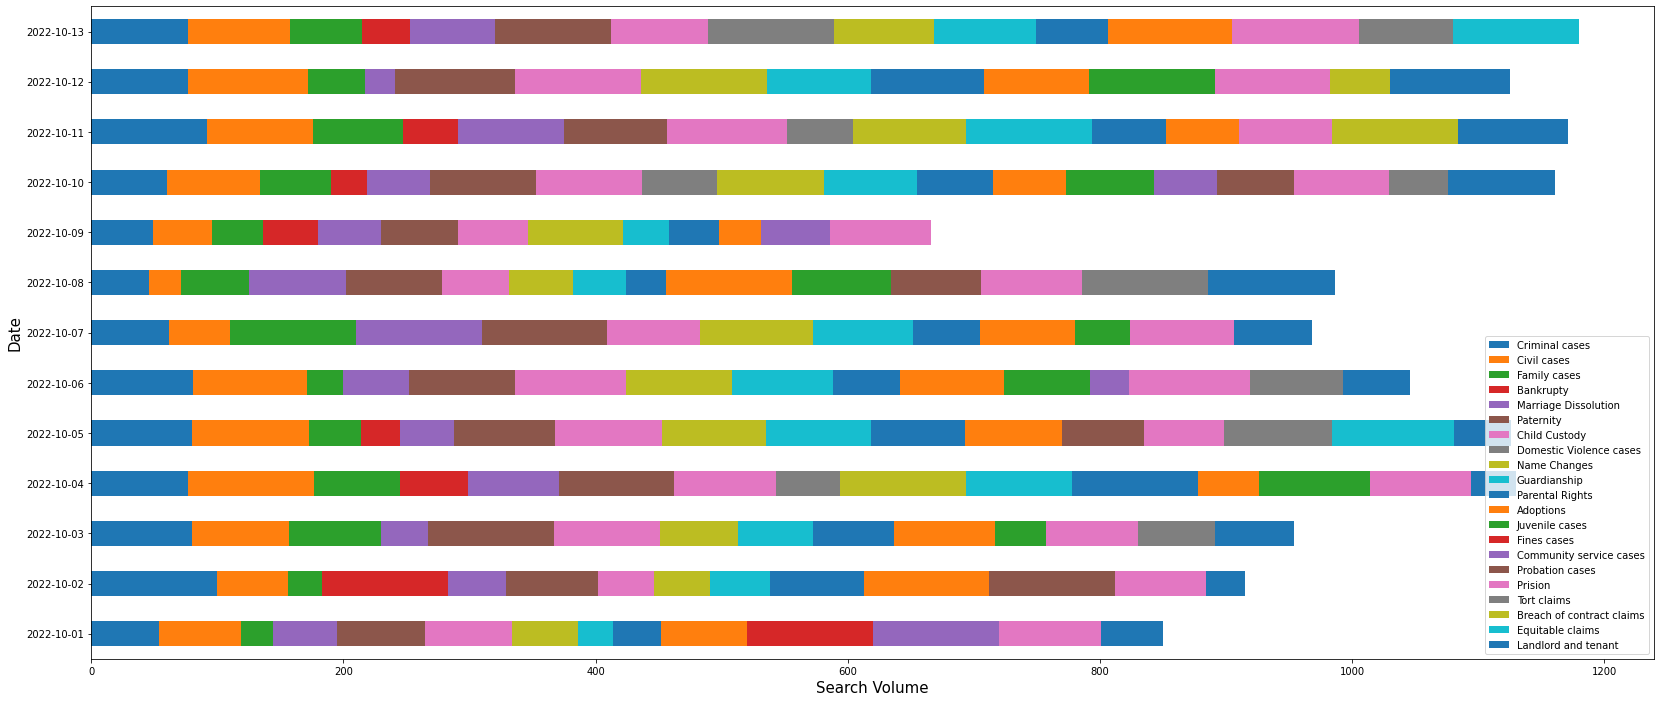

In [23]:
# 2. Encoding and make search vector
_, items = keyword_encoding(genre, law_bert)
search_encoded_vector = online_search_vector(genre, items)

# 3. Get original Semantic Embeddings
print("******* Original Semantic Law Cases Search *******")
semantic_outputs, _ = law_bert.search(user_query = my_query, top_k = 10, index = index_1)
candidate_plots = [x['judgment_summary'] for x in semantic_outputs]
embeddings = law_bert.model.encode(candidate_plots)

# 4. Compute Cosine-sim for each sentence with search_vector
cosine_scores = util.pytorch_cos_sim(search_encoded_vector, embeddings)
for (i, score) in zip(semantic_outputs, cosine_scores.numpy()[0]):
    i['search_score'] = score

# 5. Sorting by search_score
online_outputs = sorted(semantic_outputs, key=lambda x: x['search_score'], reverse = True)

print("\n\n\n\n ******* Online-based Filtering ******* \n\n")
for i, out in enumerate(online_outputs):
   print("\n === Law Cases ===")
   print("\n >> Top {} - Case name (Number) : {} ({})  \n | Cluster : {} \n | Cluster's Topics (Keywords) : {} \n | Date : {} | Judgment Issue : {} \n | Judgment Summary : {}".format(i+1, out['case_name'], out['case_number'],
                                                                                                                                                  out['Topic'], out['Topic_Modeling'],
                                                                                                                                                  out['date'], out['judgment_issue'],
                                                                                                                                                  out['judgment_summary']))

### 4-4. Dynamic Poist-filtering result

In [24]:
print("\n")
print("\n >> Write your case :", my_query)
print("\n")

# Case name (Case number) : Judgment issue (cluster_name) 
results = pd.DataFrame()
results['Only Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in original_outputs]
results['Popularity-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in p_outputs]
results['User-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in user_outputs]
results['Online-based Semantic Search'] = [item['case_name'] + str(" (" + item['case_number']+")" " : ") + item['judgment_issue'] for item in online_outputs]
results




 >> Write your case : 1차선에서 2차선으로 바꾸는 차량을 피하려다가 옆 차선 차와 충돌하였습니다.




,Only Semantic Search,Popularity-based Semantic Search,User-based Semantic Search,Online-based Semantic Search
0,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,업무상과실치사 (80도3305) : 고속도로상에서의 신뢰의 원칙과 자동차운전자의 ...,교통사고처리특례법위반 (88도1678) : 중앙선이 설치된 도로에서 다른 차량운행...
1,"교통사고처리특례법위반,도로교통법위반 (87도884) : 교통사고처리특례법 제3조 제...",특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,자동차운송사업면허취소처분취소 (84누300) : 빗길에 과속으로 운행중 중앙분리선...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...
2,손해배상(자) (96다30823) : [1] \n 도로교통법 제17...,"교통사고처리특례법위반,도로교통법위반 (87도884) : 교통사고처리특례법 제3조 제...",공직선거및선거부정방지법위반 (99노16) : 사고 장소 부근을 전후한 약 10...,"교통사고처리특례법위반,도로교통법위반 (87도884) : 교통사고처리특례법 제3조 제..."
3,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...,구상금 (99다22168) : 교통정리가 행하여지지 않는 교차로에서 좌회전하기 위하...,일반교통방해치사·일반교통방해치상·폭력행위등처벌에관한법률위반(집단·흉기등협박)·도로교...,손해배상(자) (96다30823) : [1] \n 도로교통법 제17...
4,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,교통사고처리특례법위반 (88도1678) : 중앙선이 설치된 도로에서 다른 차량운행...,보험금 (2004다71232) : [1] 안전하게 정차하기 어려운 곳에 자동차를 정...,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...
5,구상금 (99다22168) : 교통정리가 행하여지지 않는 교차로에서 좌회전하기 위하...,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...,구상금 (2000다67464) : [1] 중앙선 침범 사고에서 자기 차선을 따라 운...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...
6,특정범죄가중처벌등에관한법률위반(도주차량) (93도2562) : 일방통행 도로를 역...,구상금 (95다23590) : [1] \n 도로교통법 제17조 제1...,손해배상(기) (2001나44354) : 자동차 운전자가 주취로 인하여 지각능력과 ...,손해배상(자) (92다29245) : 중앙선이 설치된 편도 2차선 도로의 2차선상...
7,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,손해배상(자) (96다30823) : [1] \n 도로교통법 제17...,교통사고처리특례법위반 (91도1746) : 방향지시등을 켜지 않은 채 2차선 도로...,구상금 (99다22168) : 교통정리가 행하여지지 않는 교차로에서 좌회전하기 위하...
8,교통사고처리특례법위반 (88도1678) : 중앙선이 설치된 도로에서 다른 차량운행...,특정범죄가중처벌등에관한법률위반(도주차량) (93도2562) : 일방통행 도로를 역...,특정범죄가중처벌등에관한법률위반(위험운전치상) (2020도9994) : [1] 도로교...,특정범죄가중처벌등에관한법률위반(도주차량) (93도2562) : 일방통행 도로를 역...
9,손해배상 (86다카166) : 차량끼리의 충돌로 인한 교통사고에 있어서 쌍방과실의...,손해배상 (86다카166) : 차량끼리의 충돌로 인한 교통사고에 있어서 쌍방과실의...,손해배상(자) (96다33808) : 고속도로 진행 중 돌발사태를 피하여 갓길로 급...,손해배상 (86다카166) : 차량끼리의 충돌로 인한 교통사고에 있어서 쌍방과실의...
